# Spatiotemporal trajectory of mouse organogenesis

This tutorial shows how to use the {class}`~moscot.problems.spatiotemporal.SpatioTemporalProblem` to analyze the spatiotemporal trajectory in mouse organogenesis.

:::{note}
We recommend running this tutorial on a GPU.
:::

:::{seealso}
- TODO: link to other tutorials
:::

## Imports and data loading

In [1]:
import warnings

import moscot as mt
import moscot.plotting as mpl
from moscot import datasets
from moscot.problems.spatiotemporal import SpatioTemporalProblem

import numpy as np

import matplotlib.pyplot as plt

import scanpy as sc
import squidpy as sq

warnings.simplefilter("ignore", UserWarning)

## Dataset description

The {func}`~moscot.datasets.mosta` dataset is a subset of the spatiotemporal transcriptomics atlas of the spatiotemporal transcriptomics atlas of mouse organogenesis {cite}`chen:22`. The {class}`~anndata.AnnData` object includes read-outs at three time points with embryo sections `E9.5`, `E2S1`, `E10.5`, `E2S1`, `E11.5`, and `E1S2`. The data was preprocessed by normalizing and log-transforming the counts.

In [2]:
adata = datasets.mosta()
adata

AnnData object with n_obs × n_vars = 54134 × 2000
    obs: 'annotation', 'timepoint', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'time', 'n_genes', 'total_counts_mt', 'pct_counts_mt', 'AGM_mapping', 'AGM_annotation', 'Blood vessel_mapping', 'Blood vessel_annotation', 'Brain_mapping', 'Brain_annotation', 'Branchial arch_mapping', 'Branchial arch_annotation', 'Cavity_mapping', 'Cavity_annotation', 'Connective tissue_mapping', 'Connective tissue_annotation', 'Dermomyotome_mapping', 'Dermomyotome_annotation', 'Dorsal root ganglion_mapping', 'Dorsal root ganglion_annotation', 'GI tract_mapping', 'GI tract_annotation', 'Head mesenchyme_mapping', 'Head mesenchyme_annotation', 'Heart_mapping', 'Heart_annotation', 'Inner ear_mapping', 'Inner ear_annotation', 'Jaw and tooth_mapping', 'Jaw and tooth_annotation', 'Liver_mapping', 'Liv

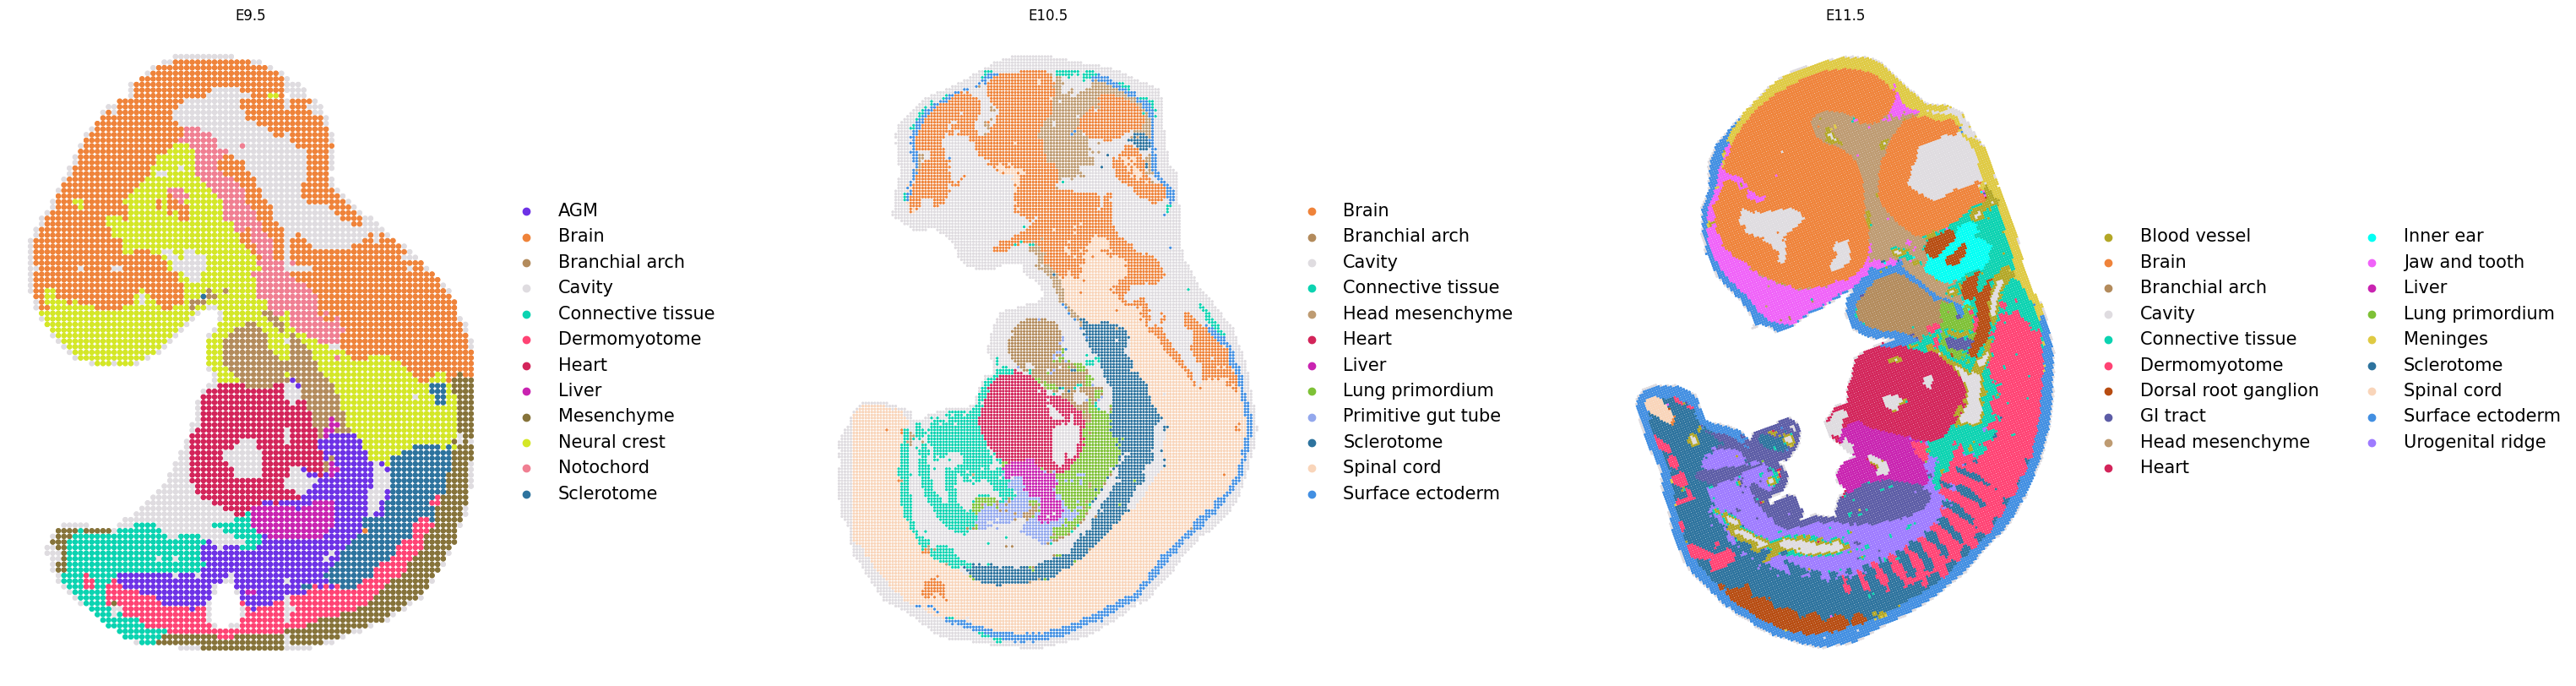

In [3]:
library_ids = list(adata.obs["timepoint"].cat.categories)
sq.pl.spatial_scatter(
    adata,
    color="annotation",
    frameon=False,
    shape=None,
    library_key="timepoint",
    library_id=library_ids,
    title=library_ids,
    figsize=(10, 10),
    size=[50, 5, 5],
    legend_fontsize=15,
)

## Prepare and solve the {class}`~moscot.problems.spatiotemporal.SpatioTemporalProblem`

We initialize and prepare the problem by specifying the `time_key`, which specifies the different time points. Moreover, the `spatial_key` defines the key in {attr}`~anndata.AnnData.obsm` where the spatial coordinates are saved. The `joint_attr` defines where the single-cell data is stored. Here, we don't use a precomputed embedding but specify via `callback` that PCA should be run on {attr}`~anndata.AnnData.X`.

In [4]:
stp = SpatioTemporalProblem(adata)
stp = stp.prepare(
    time_key="time",
    spatial_key="spatial",
    joint_attr=None,
    callback="local-pca",
)

INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  


To {meth}`~moscot.problems.spatiotemporal.SpatioTemporalProblem.solve` the problem we specify `alpha` (in $(0, 1]$), which defines the influence of the spatial coordinates as opposed to the single-cell data. We set `epsilon=0`, which is only possible in the low-rank case. As the data is large, we use low-rank optimal transport to decrease the computational complexity. We use `initializer='rank2'` to improve the speed of convergence.

In [5]:
stp = stp.solve(
    alpha=0.85, epsilon=0, rank=700, max_iterations=1000, initializer="rank2"
)

INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(5870, 18292)].                                 
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(18292, 29972)].                                


## Cell transitions

We can now analyze which cell types are mapped to which cell type across time using the {meth}`~moscot.problems.spatiotemporal.SpatioTemporalProblem.cell_transition` method. As different time points have different cell types, it is not straightforward to assess the mapping. To improve the visualization, we order the annotations such that in the upper left we have the same cell types.

In [6]:
celltypes_source_1 = adata[adata.obs["time"] == 9.5].obs["annotation"].cat.categories
celltypes_target_1 = adata[adata.obs["time"] == 10.5].obs["annotation"].cat.categories
celltypes_intersection_1 = list(
    set(celltypes_source_1).intersection(celltypes_target_1)
)
source_ordered_1 = celltypes_intersection_1 + list(
    set(celltypes_source_1) - set(celltypes_target_1)
)
target_ordered_1 = celltypes_intersection_1 + list(
    set(celltypes_target_1) - set(celltypes_source_1)
)

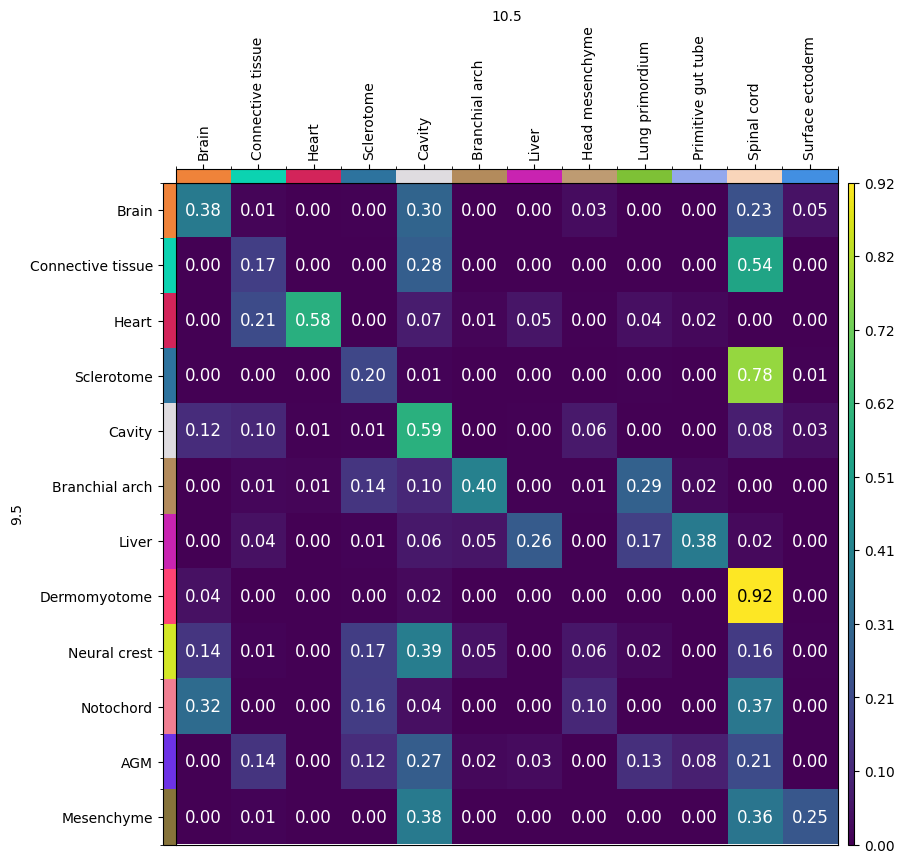

In [7]:
stp.cell_transition(
    source=9.5,
    target=10.5,
    source_groups={"annotation": source_ordered_1},
    target_groups={"annotation": target_ordered_1},
    forward=True,
)
mpl.cell_transition(stp, fontsize=12, figsize=(7, 7))

Most of the cell types seem to map to themselves, such as the `Heart` cells. Moreover, we can see that many cells are mapped to `Cavity`, which is to be expected.

In [8]:
celltypes_source_2 = adata[adata.obs["time"] == 10.5].obs["annotation"].cat.categories
celltypes_target_2 = adata[adata.obs["time"] == 11.5].obs["annotation"].cat.categories
celltypes_intersection_2 = list(
    set(celltypes_source_2).intersection(celltypes_target_2)
)
source_ordered_2 = celltypes_intersection_2 + list(
    set(celltypes_source_2) - set(celltypes_target_2)
)
target_ordered_2 = celltypes_intersection_2 + list(
    set(celltypes_target_2) - set(celltypes_source_2)
)

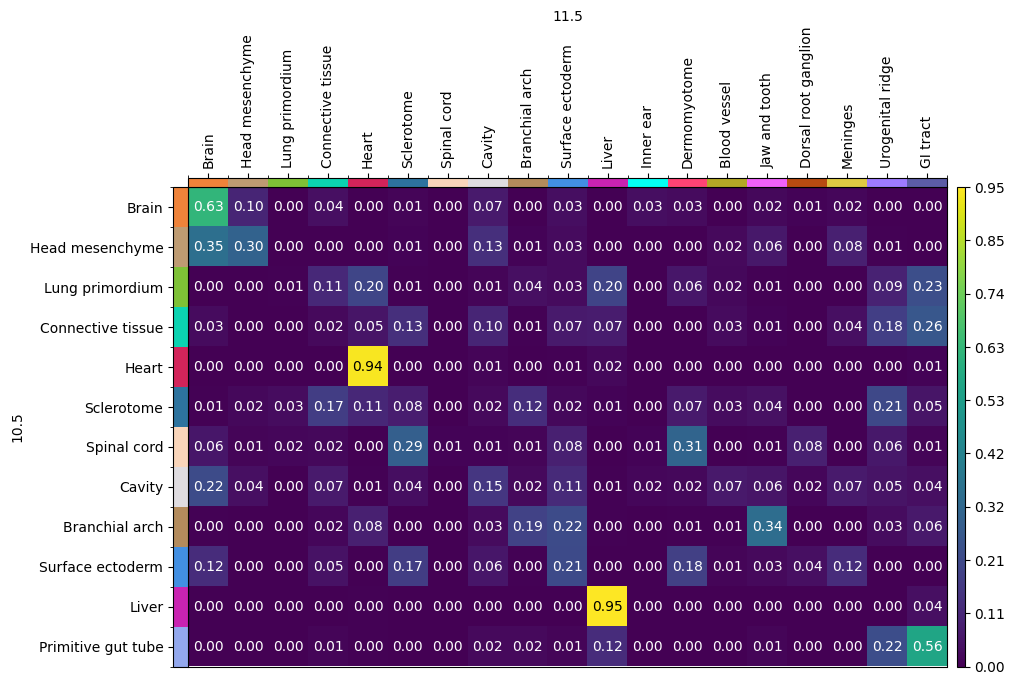

In [9]:
stp.cell_transition(
    source=10.5,
    target=11.5,
    source_groups={"annotation": source_ordered_2},
    target_groups={"annotation": target_ordered_2},
    forward=True,
)
mpl.cell_transition(stp, fontsize=10, figsize=(8, 8))

## Pushing cells across space and time

Next, we can visualize the predicted spatial destination of the cells using the {meth}`~moscot.problems.spatiotemporal.SpatioTemporalProblem.push` method. Below we focus on the `Heart` cells.

In [10]:
for (start, end), prob in stp.problems.items():
    stp.push(
        source=start,
        target=end,
        data="annotation",
        subset="Heart",
        key_added="Heart_mapping",
    )

In the first column, we plot the spatial locations of the heart cells at `E10.5`. In the second row, we show the `Heart` cells projected onto the the spatial coordinates at `E11.5`.

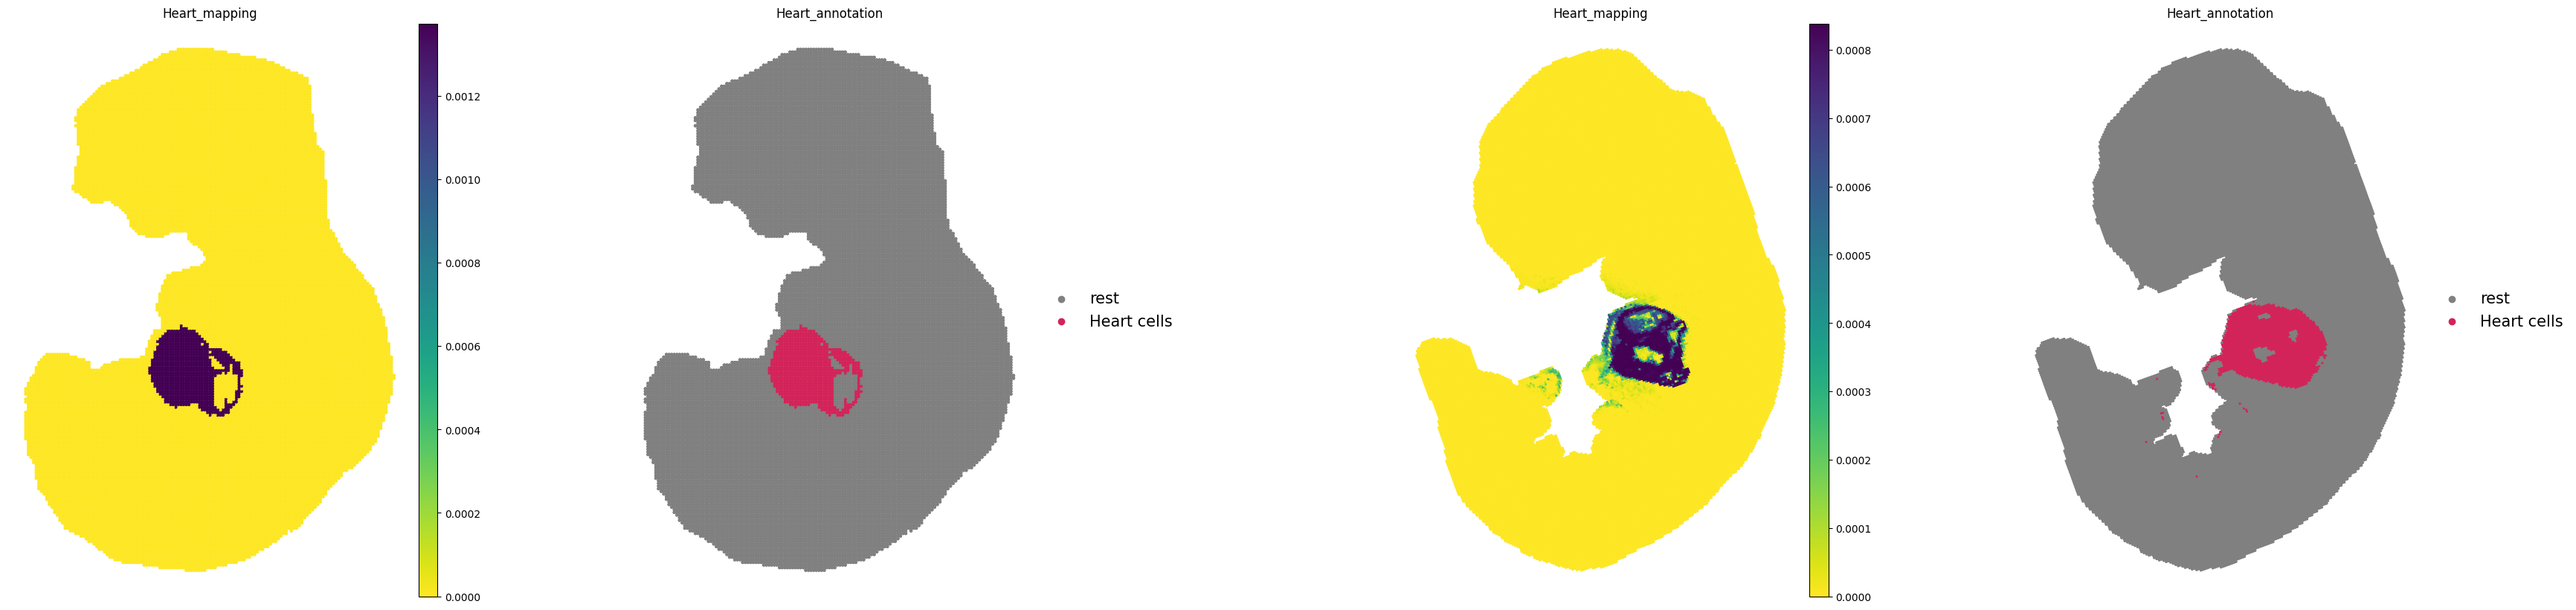

In [11]:
library_ids = ["E10.5", "E11.5"]

sq.pl.spatial_scatter(
    adata,
    color=["Heart_mapping", "Heart_annotation"],
    frameon=False,
    shape=None,
    library_key="timepoint",
    library_id=library_ids,
    cmap="viridis_r",
    figsize=(10, 10),
    size=[20, 10],
    legend_fontsize=15,
)